# 2 Scratch detection
2.1 The scratch detection algorithm
2.2 Quantification of wound area change
2.3 Velocity of the leading edge
2.4 Distance fields

In [8]:
import numpy as np
from shapely.geometry.polygon import Polygon
from imageio.v2 import imread
from skimage.filters import gaussian
from skimage.measure import find_contours, label, regionprops_table
from skimage.morphology import dilation, disk
from scipy.ndimage import binary_fill_holes
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string 
from knockdown_nrs import knockdown_nrs

In [9]:
# Define main path
main_path = '/Users/olyssa/Desktop/BA_data'

## 2.1 The scratch detection algorithm

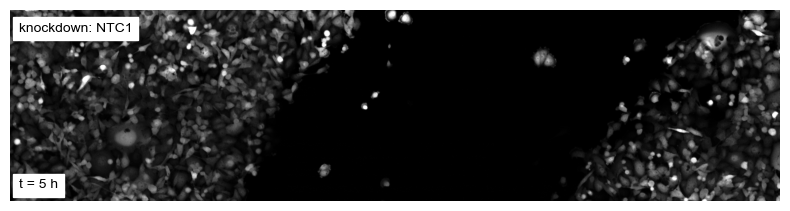

In [10]:
# Read original image
img_stack = imread(uri=main_path+'/005023_hyperstack_drift_corrected_cyto_MIST_cut.tif')
t = 5
img = img_stack[t]

# Display original image
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.imshow(img, cmap='Greys_r')
ax.text(20, 50, f'knockdown: NTC1', color="black", backgroundcolor='white', fontsize=10)
ax.text(20, 410, f't = {t} h', color="black", backgroundcolor='white', fontsize=10)
ax.set_axis_off()
plt.tight_layout()
plt.show()

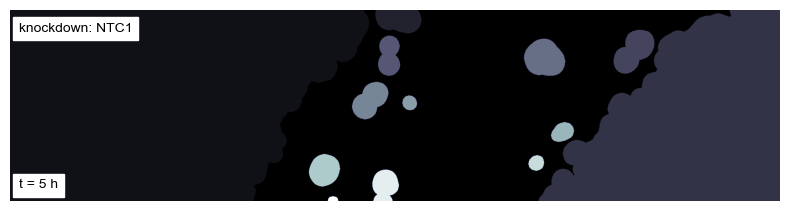

In [4]:
# Create object mask
def get_object_mask(img, gaussian_sigma=5, dilation_disk_size=10, th=0.004): # 3, 0.005

   if gaussian_sigma is not None:
      img_f = gaussian(img, gaussian_sigma)
   else:
      img_f = img

   img_b = np.where(img_f > th, 1, 0).astype(bool)
   if dilation_disk_size is not None:
      img_b = dilation(img_b, disk(dilation_disk_size))

   mask = label(img_b)

   return mask

# Fill object mask
def fill_boundary_object(mask):

   for l in np.unique(mask):

      if l == 0: continue
      object_mask = np.where(mask == l, 1, 0)

      lower_bounds = np.argwhere(np.diff(object_mask[-1, :]))
      if len(lower_bounds) > 0:
         lower_bounds = np.min(lower_bounds), np.max(lower_bounds)
         # print(l,lower_bounds)
         mask[-1, lower_bounds[0]:lower_bounds[1]] = l

      upper_bounds = np.argwhere(np.diff(object_mask[0, :]))
      if len(upper_bounds) > 0:
         upper_bounds = np.min(upper_bounds), np.max(upper_bounds)
         mask[0, upper_bounds[0]:upper_bounds[1]] = l

      left_bounds = np.argwhere(np.diff(object_mask[:, 0]))
      if len(left_bounds) > 0:
         left_bounds = np.min(left_bounds), np.max(left_bounds)
         mask[left_bounds[0]:left_bounds[1],0] = l

      right_bounds = np.argwhere(np.diff(object_mask[:, -1]))
      if len(right_bounds) > 0:
         right_bounds = np.min(right_bounds), np.max(right_bounds)
         mask[right_bounds[0]:right_bounds[1], -1] = l

      return mask

mask = get_object_mask(img)
mask_filled = fill_boundary_object(mask)

# Display mask filled and labeled
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.imshow(mask_filled, cmap='bone')
ax.text(20, 50, f'knockdown: NTC1', color="black", backgroundcolor='white', fontsize=10)
ax.text(20, 410, f't = {t} h', color="black", backgroundcolor='white', fontsize=10)
ax.set_axis_off()
plt.tight_layout()
plt.show()

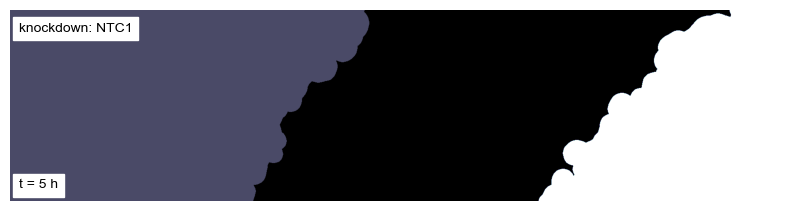

In [5]:
# Select the two largest regions (left and right tissue)
def select_tissue(mask_filled):
    rp = pd.DataFrame(regionprops_table(mask_filled, properties=["label", "area"]))
    rp = rp.sort_values("area", ascending=False).iloc[:2] # only take the two biggest areas
    mask_labeled = np.where(np.isin(mask_filled, rp.label), mask_filled, 0)
    
    return mask_labeled

mask_labeled = select_tissue(mask_filled)

# Display two largest regions
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.imshow(mask_labeled, cmap='bone')
ax.text(20, 50, f'knockdown: NTC1', color="black", backgroundcolor='white', fontsize=10)
ax.text(20, 410, f't = {t} h', color="black", backgroundcolor='white', fontsize=10)
ax.set_axis_off()
plt.tight_layout()
plt.show()

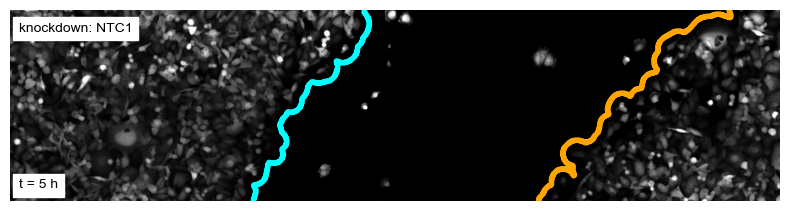

In [6]:
# Get border coords of tissue: get objects, fill objects, find contour coords (skimage.measure function)
def get_border_coords(mask_labeled):
    c = find_contours(binary_fill_holes(mask_labeled))

    c2 = []
    for i, con in enumerate(c):
       if i in list(np.argsort([len(c) for c in c], )[-2:]):
          c2.append(con)

    scratch_border_right = [c2[1][:, 1], c2[1][:, 0]]
    scratch_border_left = [c2[0][:, 1], c2[0][:, 0]]

    return scratch_border_left, scratch_border_right

scratch_border_left, scratch_border_right = get_border_coords(mask_labeled)

mask = get_object_mask(img)
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.imshow(img, cmap='Greys_r')
ax.plot(scratch_border_left[0], scratch_border_left[1], color='cyan', linewidth=4)
ax.plot(scratch_border_right[0], scratch_border_right[1], color='orange', linewidth=4)
ax.text(20, 50, f'knockdown: NTC1', color="black", backgroundcolor='white', fontsize=10)
ax.text(20, 410, f't = {t} h', color="black", backgroundcolor='white', fontsize=10)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [7]:
# Get contour coords as df type (not used)
def get_contour_dataframe(rp, mask):
   contours = []
   for l in rp.label:
      filled_mask = binary_fill_holes(np.where(mask == l, 1, 0))
      c = find_contours(filled_mask, 0)
      for cc in c:
         contours.append({"curve": cc, "parent_object": l, "length": len(cc)})
   contours = pd.DataFrame(contours)

   return contours

## 2.2 Quantification of wound area change

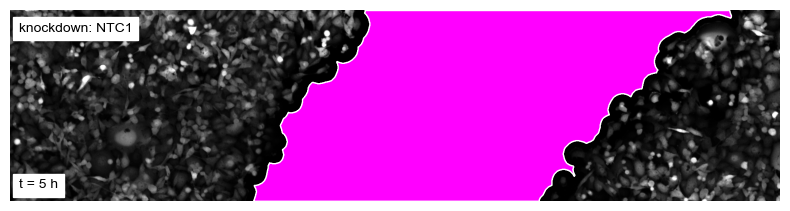

Scratch area = 310483.5 px


In [11]:
# Create a polygon with border coords with shapely function
def create_polygon_scratch(scratch_border_left, scratch_border_right):

    x = [*scratch_border_left[0][::-1], *scratch_border_right[0][::-1]]
    y = [*scratch_border_left[1][::-1], *scratch_border_right[1][::-1]]

    coords = []

    for i in range(len(x)):
        coords.append((x[i], y[i]))
    polygon_scratch = Polygon(coords)

    return polygon_scratch

from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection

def plot_polygon(ax, poly, **kwargs):
    path = Path.make_compound_path(
        Path(np.asarray(poly.exterior.coords)[:, :2]),
        *[Path(np.asarray(ring.coords)[:, :2]) for ring in poly.interiors])

    patch = PathPatch(path, **kwargs)
    collection = PatchCollection([patch], **kwargs)
    
    ax.add_collection(collection, autolim=True)
    ax.autoscale_view()
    return collection

polygon_scratch = create_polygon_scratch(scratch_border_left, scratch_border_right)

fig, ax = plt.subplots(figsize=(8, 2.5))
ax.imshow(img, cmap='Greys_r')
plot_polygon(ax, polygon_scratch, facecolor='magenta')
ax.text(20, 50, f'knockdown: NTC1', color="black", backgroundcolor='white', fontsize=10)
ax.text(20, 410, f't = {t} h', color="black", backgroundcolor='white', fontsize=10)
ax.set_axis_off()
plt.tight_layout()
plt.show()

print('Scratch area =', polygon_scratch.area, 'px')

In [ ]:
# Batch calculations of wound area for all preprocessed image files (all replicates, knockdowns and timepoints)
def create_df_scratch_area(e):
    '''
    :param e: experiment number / replicate number
    creates a dataframe with 
    '''
    
    df = pd.DataFrame()

    for k in range(len(knockdown_nrs)):
        img_stack = imread(
            uri=main_path + f'img_stacks_cut/exp{e}_imgs_cut/{knockdown_nrs[k]}_hyperstack_drift_corrected_cyto_MIST_cut.tif')
        area = []
        for t in range(17):
            if len(area) != 17:
                img = img_stack[t]
                try:
                    polygon_scratch = create_polygon_scratch(img)
                    area.append(polygon_scratch.area)
                except IndexError:
                    for ti in range(17-t):
                        area.append(np.NaN)
                    pass
            else:
                pass

        df[f'area_{knockdown_nrs[k]}'] = area

    pd.DataFrame.to_csv(self=df,
                        path_or_buf=main_path+f'/Extracted_data/feature_tables/df_scratch_area_exp{e}.csv')

# Execute scratch area detection
exp_nrs = [1, 2, 3]
for e in exp_nrs:
    create_df_scratch_area(e)

In [19]:
# Get all experimental replicate numbers of controls
plate_map = pd.read_excel(main_path+'/plate_map_knock_down_nrs.xlsx')
plate_map['knock_down_nr'] = knockdown_nrs
myh9 = plate_map[(plate_map['Gene Symbol'] == 'MYH9')]['knock_down_nr']
pou5f1 = plate_map[(plate_map['Gene Symbol'] == 'POU5F1')]['knock_down_nr']
plk1 = plate_map[(plate_map['Gene Symbol'] == 'PLK1')]['knock_down_nr']
ntc1 = plate_map[(plate_map['Gene Symbol'] == 'NTC1')]['knock_down_nr']

/var/folders/2v/_c7y979j6tjczs_z_jz_fjyw0000gn/T/ipykernel_76577/1907974121.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c[i] = c[i]/c[i][0]*100


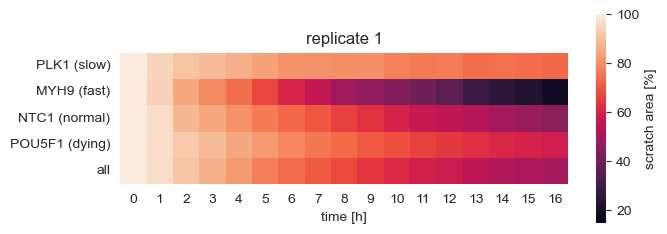

In [20]:
# Plot heatmap area change for control knockdowns of exp1
scratch_area_exp1 = pd.read_csv(main_path+'/df_scratch_area_exp1.csv')

plk1_exp1 = scratch_area_exp1[['area_'+list(plk1)[i] for i in range(len(plk1))]]
myh9_exp1 = scratch_area_exp1[['area_'+list(myh9)[i] for i in range(len(myh9))]]
ntc1_exp1 = scratch_area_exp1[['area_'+list(ntc1)[i] for i in range(len(ntc1))]]
pou5f1_exp1 = scratch_area_exp1[['area_'+list(pou5f1)[i] for i in range(len(pou5f1))]]
all_exp1 = scratch_area_exp1.iloc[:, 2:]

# Perform normalization on scratch area
for c in [plk1_exp1, myh9_exp1, ntc1_exp1, pou5f1_exp1, all_exp1]:
    for i in c.columns:
        c[i] = c[i]/c[i][0]*100

# Calculate mean from all data
scratch_area_exp1_controls = [plk1_exp1.mean(axis=1), myh9_exp1.mean(axis=1), ntc1_exp1.mean(axis=1), pou5f1_exp1.mean(axis=1), all_exp1.mean(axis=1)]
scratch_area_exp1_controls = pd.DataFrame(scratch_area_exp1_controls)
scratch_area_exp1_controls = scratch_area_exp1_controls.T
scratch_area_exp1_controls.columns = ['PLK1 (slow)', 'MYH9 (fast)', 'NTC1 (normal)', 'POU5F1 (dying)', 'all']

# Calculate standard deviation
scratch_area_exp1_controls_std = [np.std(plk1_exp1, axis=1), np.std(myh9_exp1, axis=1), np.std(ntc1_exp1, axis=1),
                                  np.std(pou5f1_exp1, axis=1), np.std(all_exp1, axis=1)]
scratch_area_exp1_controls_std = pd.DataFrame(scratch_area_exp1_controls_std)
scratch_area_exp1_controls_std = scratch_area_exp1_controls_std.T
scratch_area_exp1_controls_std.columns = ['PLK1 (slow)', 'MYH9 (fast)', 'NTC1 (normal)', 'POU5F1 (dying)', 'all']

# Heatmap exp1 - 4 controls and all knockdowns over time
fig, ax = plt.subplots(figsize=(7, 2.5))
sns.heatmap(scratch_area_exp1_controls.T, 
            cmap='rocket', 
            cbar_kws={'label': 'scratch area [%]',
                      # 'location': 'bottom'
                      },
            vmin=15, vmax=100, 
            square=True)
ax.set_xlabel('time [h]')
ax.set_title(f'replicate 1')
#plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

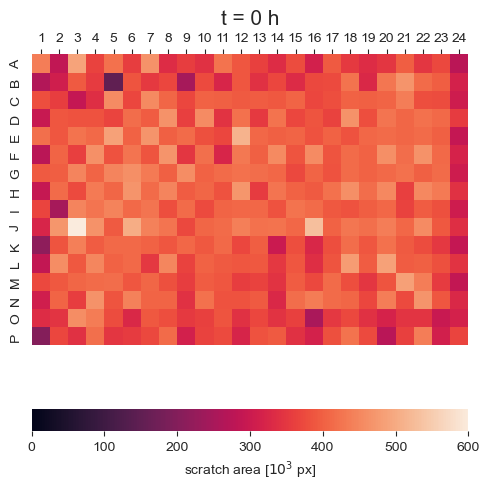

In [21]:
# Heatmap exp1 whole plate at t = 0 h
fig, ax = plt.subplots(figsize=(5, 5))

t = 0
exp1 = scratch_area_exp1.iloc[t]
exp1 = exp1[2:].values.reshape(16, 24) / 1000
sns.heatmap(exp1,
            cmap='rocket',
            cbar_kws={'label': 'scratch area [$10^3$ px]',
                      'location': 'bottom'
                      },
            vmin=0, vmax=600,
            square=True)
ax.set_title(f't = {t} h', fontsize=15)
ax.xaxis.tick_top()

plt.xticks(np.arange(0.5, 24.5), np.arange(1, 25))
plt.yticks(np.arange(0.5, 16.5), list(string.ascii_uppercase[:16]))

plt.tight_layout()
plt.show()

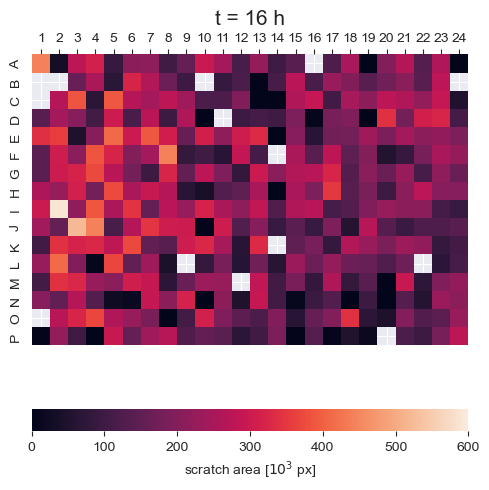

In [22]:
# Heatmap exp1 whole plate at t = 16 h
t = 16
exp1 = scratch_area_exp1.iloc[t]
exp1 = exp1[2:].values.reshape(16, 24) / 1000

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(exp1,
            cmap='rocket',
            cbar_kws={'label': 'scratch area [$10^3$ px]',
                      'location': 'bottom'
                      },
            vmin=0, vmax=600,
            square=True)
ax.set_title(f't = {t} h', fontsize=15)
ax.xaxis.tick_top()

plt.xticks(np.arange(0.5, 24.5), np.arange(1, 25))
plt.yticks(np.arange(0.5, 16.5), list(string.ascii_uppercase[:16]))

plt.tight_layout()
plt.show()

## 2.3 Velocity of the leading edge

In [ ]:
# Calculation for leading edge velocity of one control knockdown of one experimental replicate
samples = np.linspace(0, 440, 100)
e = 1
for k in myh9:
    try:
        img_stack = imread(
                    uri=main_path + f'img_stacks_cut/exp{e}_imgs_cut/{k}_hyperstack_drift_corrected_cyto_MIST_cut.tif')

        list_borders_left = []
        list_borders_right = []

        # Get positions of leading edges over time
        for t in range(17):
            scratch_border_left, scratch_border_right = get_border_coords(img_stack[t])
            line_left = np.polyfit(scratch_border_left[0], scratch_border_left[1], 1)
            line_right = np.polyfit(scratch_border_right[0], scratch_border_right[1], 1)

            border_function_left = (samples - line_left[1]) / line_left[0]
            border_function_right = (samples - line_right[1]) / line_right[0]

            list_borders_left.append(border_function_left)
            list_borders_right.append(border_function_right)

        # Calculate velocities
        velocities_left = []
        velocities_right = []
        vel_left_list = []
        vel_right_list = []
        for t in range(16):
            vel_left = np.array(list_borders_left[t+1])-np.array(list_borders_left[t])
            vel_right = np.array(list_borders_right[t+1]) - np.array(list_borders_right[t])

            vel_left_list.append(np.mean(vel_left))
            vel_right_list.append(np.mean(vel_right))

        velocities_left = np.concatenate((velocities_left, vel_left_list))
        velocities_right = np.concatenate((velocities_right, vel_right_list))

    except IndexError:
        pass

velocities = np.concatenate((velocities_left, velocities_right))
velocities_myh9_exp3 = [abs(x)/1300 for x in velocities]

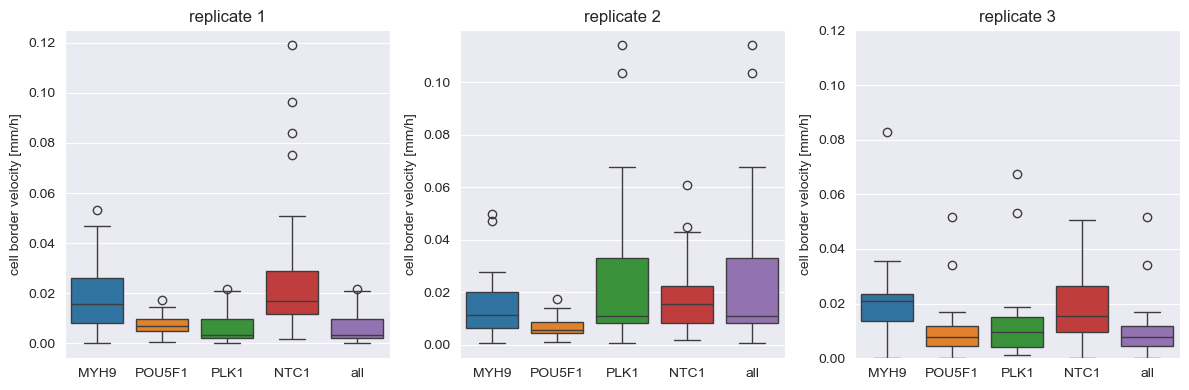

In [107]:
# Plot leading edge velocities
data_velocity = pd.read_excel(main_path+'/leading_edge_velocites_controls_and_all_knockdowns_rep1_rep2_rep3.xlsx')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for e in [1, 2, 3]:
    sns.boxplot([data_velocity[f'MYH9_exp{e}'], data_velocity[f'POU5F1_exp{e}'], data_velocity[f'PLK1_exp{e}'], data_velocity[f'NTC1_exp{e}'], data_velocity[f'all_exp{e}']], ax=ax[e-1])
    ax[e-1].set_ylabel('cell border velocity [mm/h]')
    ax[e-1].set_xticks(range(5))
    ax[e-1].set_xticklabels(['MYH9', 'POU5F1', 'PLK1', 'NTC1', 'all'])
    ax[e-1].title.set_text(f'replicate {e}')
plt.ylim(0, 0.12)
plt.tight_layout()
plt.show()

## 2.4 Distance fields

In [11]:
import skfmm

In [12]:
def get_minimum_distance_field(mask): # for feature extraction: KeyError: 'length'

   distance_fields = []
   for l in np.unique(mask):
      if l == 0: continue

      d = skfmm.distance(binary_fill_holes(np.where(mask == l, 1, 0)))
      d = np.where(mask == l, d, np.nan)
      distance_fields.append(d)
   d = np.nanmin(np.array(distance_fields), axis=0)
   return d

In [ ]:
mask = imread(uri=main_path+'/masks_stack_005023_exp1_cyto_cut.tif')
get_minimum_distance_field(mask)